In [57]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from collections import defaultdict

class HillClimbingScheduler:
    def __init__(self):
        # Constants for the hill climbing algorithm
        self.MAX_ITERATIONS = 1000
        self.MAX_NEIGHBORS = 100
        self.NO_IMPROVEMENT_LIMIT = 50
        
        # Time slots and days
        self.time_slots = ["7:30-8:30", "8:30-9:30", "9:30-10:30", "10:30-11:30", 
                          "1:00-2:00", "2:00-3:00", "3:00-4:00", "4:00-5:00"]
        self.days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
        
        # Sample data for demonstration
        self.teachers = self._create_sample_teachers(10)
        self.sections = self._create_sample_sections(5)
        self.subjects = self._create_sample_subjects(8)
        
        # Create mappings for quick reference
        self.teacher_subjects = self._map_teacher_subjects()
        
        # For visualization
        self.score_history = []
        self.teacher_conflicts_history = []
        self.section_conflicts_history = []
        self.load_variance_history = []
        self.suitability_history = []
        
    def _create_sample_teachers(self, num_teachers):
        """Create sample teachers for demonstration"""
        teachers = []
        for i in range(1, num_teachers + 1):
            # Each teacher has an ID and a preferred subject
            teachers.append({
                'id': i,
                'name': f'Teacher {i}',
                'subject_id': random.randint(1, 8)
            })
        return teachers
    
    def _create_sample_sections(self, num_sections):
        """Create sample sections for demonstration"""
        sections = []
        for i in range(1, num_sections + 1):
            sections.append({
                'id': i,
                'name': f'Section {i}',
                'grade_level': random.randint(7, 12)
            })
        return sections
    
    def _create_sample_subjects(self, num_subjects):
        """Create sample subjects for demonstration"""
        subjects = []
        for i in range(1, num_subjects + 1):
            subjects.append({
                'id': i,
                'name': f'Subject {i}'
            })
        return subjects
        
    def _map_teacher_subjects(self):
        """Map teachers to their subjects based on the subject_id relationship"""
        teacher_subjects = defaultdict(list)
        for teacher in self.teachers:
            # Add the directly assigned subject
            teacher_subjects[teacher['id']].append(teacher['subject_id'])
            # Also add 1-2 random additional subjects
            for _ in range(random.randint(1, 2)):
                random_subject = random.randint(1, 8)
                if random_subject not in teacher_subjects[teacher['id']]:
                    teacher_subjects[teacher['id']].append(random_subject)
        
        return teacher_subjects
    
    def _create_initial_schedule(self):
        """Create an initial random schedule"""
        schedule = []
        
        # Create a schedule for each section and required subject
        for section in self.sections:
            for subject in self.subjects:
                # Skip if section doesn't need this subject (implement your own logic)
                if not self._section_needs_subject(section, subject):
                    continue
                
                # Find suitable teachers for this subject
                suitable_teachers = [teacher['id'] for teacher in self.teachers 
                                    if subject['id'] in self.teacher_subjects[teacher['id']]]
                
                if not suitable_teachers:
                    suitable_teachers = [teacher['id'] for teacher in self.teachers]
                
                # Randomly select day, time, and teacher
                day = random.choice(self.days)
                time_slot = random.choice(self.time_slots)
                teacher_id = random.choice(suitable_teachers)
                
                # Add to schedule
                schedule.append({
                    'day': day,
                    'time_slot': time_slot,
                    'teacher_id': teacher_id,
                    'section_id': section['id'],
                    'subject_id': subject['id']
                })
        
        return schedule
    
    def _section_needs_subject(self, section, subject):
        """Determine if a section needs a particular subject"""
        # Simple logic: sections need 70% of subjects
        return random.random() < 0.7
    
    def _calculate_score(self, schedule):
        """Calculate a score for the schedule (higher is better)"""
        # 1. Teacher conflicts (lower is better)
        teacher_slots = defaultdict(int)
        for entry in schedule:
            key = (entry['teacher_id'], entry['day'], entry['time_slot'])
            teacher_slots[key] += 1
        
        teacher_conflicts = sum(count - 1 for count in teacher_slots.values() if count > 1)
        
        # 2. Section conflicts (lower is better)
        section_slots = defaultdict(int)
        for entry in schedule:
            key = (entry['section_id'], entry['day'], entry['time_slot'])
            section_slots[key] += 1
        
        section_conflicts = sum(count - 1 for count in section_slots.values() if count > 1)
        
        # 3. Teacher load balance (lower is better)
        teacher_loads = defaultdict(int)
        for entry in schedule:
            teacher_loads[entry['teacher_id']] += 1
        
        avg_load = sum(teacher_loads.values()) / max(len(teacher_loads), 1)
        load_variance = sum((load - avg_load) ** 2 for load in teacher_loads.values()) / max(len(teacher_loads), 1)
        
        # 4. Teacher-subject suitability (higher is better)
        suitability = 0
        for entry in schedule:
            if entry['subject_id'] in self.teacher_subjects[entry['teacher_id']]:
                suitability += 1
        
        # Combined score (higher is better)
        score = (
            -10 * teacher_conflicts
            -10 * section_conflicts
            -2 * load_variance
            +1 * suitability
        )
        
        return score, {
            'teacher_conflicts': teacher_conflicts,
            'section_conflicts': section_conflicts,
            'load_variance': load_variance,
            'suitability': suitability
        }
    
    def _get_neighbor(self, schedule):
        """Generate a neighboring schedule by making a small change"""
        neighbor = [entry.copy() for entry in schedule]  # Deep copy
        
        # Select a random entry to modify
        idx = random.randint(0, len(neighbor) - 1)
        
        # Choose what to modify (day, time_slot, or teacher)
        modification = random.choice(['day', 'time_slot', 'teacher_id'])
        
        if modification == 'day':
            neighbor[idx]['day'] = random.choice(self.days)
        elif modification == 'time_slot':
            neighbor[idx]['time_slot'] = random.choice(self.time_slots)
        else:  # teacher_id
            suitable_teachers = [teacher['id'] for teacher in self.teachers 
                                if neighbor[idx]['subject_id'] in self.teacher_subjects[teacher['id']]]
            
            if not suitable_teachers:
                suitable_teachers = [teacher['id'] for teacher in self.teachers]
            
            neighbor[idx]['teacher_id'] = random.choice(suitable_teachers)
        
        return neighbor
    
    def climb(self):
        """Execute hill climbing algorithm to find an optimized schedule"""
        # Generate initial solution
        current_schedule = self._create_initial_schedule()
        current_score, metrics = self._calculate_score(current_schedule)
        
        # Record initial state
        self.score_history.append(current_score)
        self.teacher_conflicts_history.append(metrics['teacher_conflicts'])
        self.section_conflicts_history.append(metrics['section_conflicts'])
        self.load_variance_history.append(metrics['load_variance'])
        self.suitability_history.append(metrics['suitability'])
        
        print(f"Initial schedule score: {current_score}")
        print(f"Initial metrics: {metrics}")
        
        iteration = 0
        no_improvement_count = 0
        
        while iteration < self.MAX_ITERATIONS and no_improvement_count < self.NO_IMPROVEMENT_LIMIT:
            # Generate neighbors
            best_neighbor = None
            best_neighbor_score = float('-inf')
            
            for _ in range(self.MAX_NEIGHBORS):
                neighbor = self._get_neighbor(current_schedule)
                neighbor_score, _ = self._calculate_score(neighbor)
                
                if neighbor_score > best_neighbor_score:
                    best_neighbor = neighbor
                    best_neighbor_score = neighbor_score
            
            # Record history (for visualization)
            _, metrics = self._calculate_score(best_neighbor)
            self.score_history.append(best_neighbor_score)
            self.teacher_conflicts_history.append(metrics['teacher_conflicts'])
            self.section_conflicts_history.append(metrics['section_conflicts'])
            self.load_variance_history.append(metrics['load_variance'])
            self.suitability_history.append(metrics['suitability'])
            
            # If best neighbor is better than current, move to it
            if best_neighbor_score > current_score:
                current_schedule = best_neighbor
                current_score = best_neighbor_score
                print(f"Iteration {iteration}: Found better schedule with score {current_score}")
                print(f"Metrics: {metrics}")
                no_improvement_count = 0
            else:
                no_improvement_count += 1
            
            iteration += 1
        
        final_score, final_metrics = self._calculate_score(current_schedule)
        print(f"Final schedule score: {final_score}")
        print(f"Final metrics: {final_metrics}")
        print(f"Total iterations: {iteration}")
        print(f"Stopped after {no_improvement_count} iterations without improvement")
        
        return current_schedule, iteration
    
    def visualize_progress(self):
        """Visualize the progress of the hill climbing algorithm"""
        # Create a figure with multiple subplots
        fig = plt.figure(figsize=(15, 10))
        fig.suptitle('Hill Climbing Algorithm Progress', fontsize=16)
        
        # 1. Overall score over iterations
        ax1 = fig.add_subplot(2, 2, 1)
        ax1.plot(self.score_history, 'b-', linewidth=2)
        ax1.set_title('Overall Score Evolution')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Score (higher is better)')
        ax1.grid(True)
        
        # 2. Conflicts over iterations
        ax2 = fig.add_subplot(2, 2, 2)
        ax2.plot(self.teacher_conflicts_history, 'r-', label='Teacher Conflicts')
        ax2.plot(self.section_conflicts_history, 'g-', label='Section Conflicts')
        ax2.set_title('Scheduling Conflicts')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Number of Conflicts')
        ax2.legend()
        ax2.grid(True)
        
        # 3. Load variance over iterations
        ax3 = fig.add_subplot(2, 2, 3)
        ax3.plot(self.load_variance_history, 'y-')
        ax3.set_title('Teacher Load Balance')
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Load Variance (lower is better)')
        ax3.grid(True)
        
        # 4. Suitability over iterations
        ax4 = fig.add_subplot(2, 2, 4)
        ax4.plot(self.suitability_history, 'm-')
        ax4.set_title('Teacher-Subject Suitability')
        ax4.set_xlabel('Iteration')
        ax4.set_ylabel('Suitability Score (higher is better)')
        ax4.grid(True)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        return fig
    
    def visualize_final_schedule(self, schedule):
        """Visualize the final schedule as a heatmap"""
        # Create a matrix to represent the schedule
        # Rows: Days x Time slots
        # Columns: Sections
        
        day_time_pairs = [(day, time) for day in self.days for time in self.time_slots]
        section_ids = [section['id'] for section in self.sections]
        
        # Create a mapping between day-time pairs and indices
        day_time_to_index = {pair: idx for idx, pair in enumerate(day_time_pairs)}
        
        # Initialize the matrix with zeros
        matrix = np.zeros((len(day_time_pairs), len(section_ids)))
        
        # Fill the matrix with teacher IDs
        for entry in schedule:
            day_time = (entry['day'], entry['time_slot'])
            row = day_time_to_index[day_time]
            col = section_ids.index(entry['section_id'])
            matrix[row, col] = entry['teacher_id']
        
        # Create figure
        fig, ax = plt.figure(figsize=(12, 15)), plt.subplot(111)
        
        # Create heatmap
        cax = ax.matshow(matrix, cmap='viridis')
        fig.colorbar(cax, label='Teacher ID')
        
        # Set ticks and labels
        ax.set_xticks(np.arange(len(section_ids)))
        ax.set_xticklabels([f'Section {id}' for id in section_ids])
        
        ax.set_yticks(np.arange(len(day_time_pairs)))
        ax.set_yticklabels([f"{day} {time}" for day, time in day_time_pairs])
        
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
        # Add title and labels
        ax.set_title('Final Schedule (Teacher Assignments by Day, Time and Section)')
        
        # Return the figure
        return fig



Running hill climbing algorithm...
Initial schedule score: -7.579999999999998
Initial metrics: {'teacher_conflicts': 2, 'section_conflicts': 1, 'load_variance': 3.2900000000000005, 'suitability': 29}
Iteration 0: Found better schedule with score 2.419999999999998
Metrics: {'teacher_conflicts': 2, 'section_conflicts': 0, 'load_variance': 3.2900000000000005, 'suitability': 29}
Iteration 1: Found better schedule with score 12.419999999999998
Metrics: {'teacher_conflicts': 1, 'section_conflicts': 0, 'load_variance': 3.2900000000000005, 'suitability': 29}
Iteration 2: Found better schedule with score 22.419999999999998
Metrics: {'teacher_conflicts': 0, 'section_conflicts': 0, 'load_variance': 3.2900000000000005, 'suitability': 29}
Iteration 3: Found better schedule with score 24.02
Metrics: {'teacher_conflicts': 0, 'section_conflicts': 0, 'load_variance': 2.4899999999999998, 'suitability': 29}
Iteration 4: Found better schedule with score 24.82
Metrics: {'teacher_conflicts': 0, 'section_con

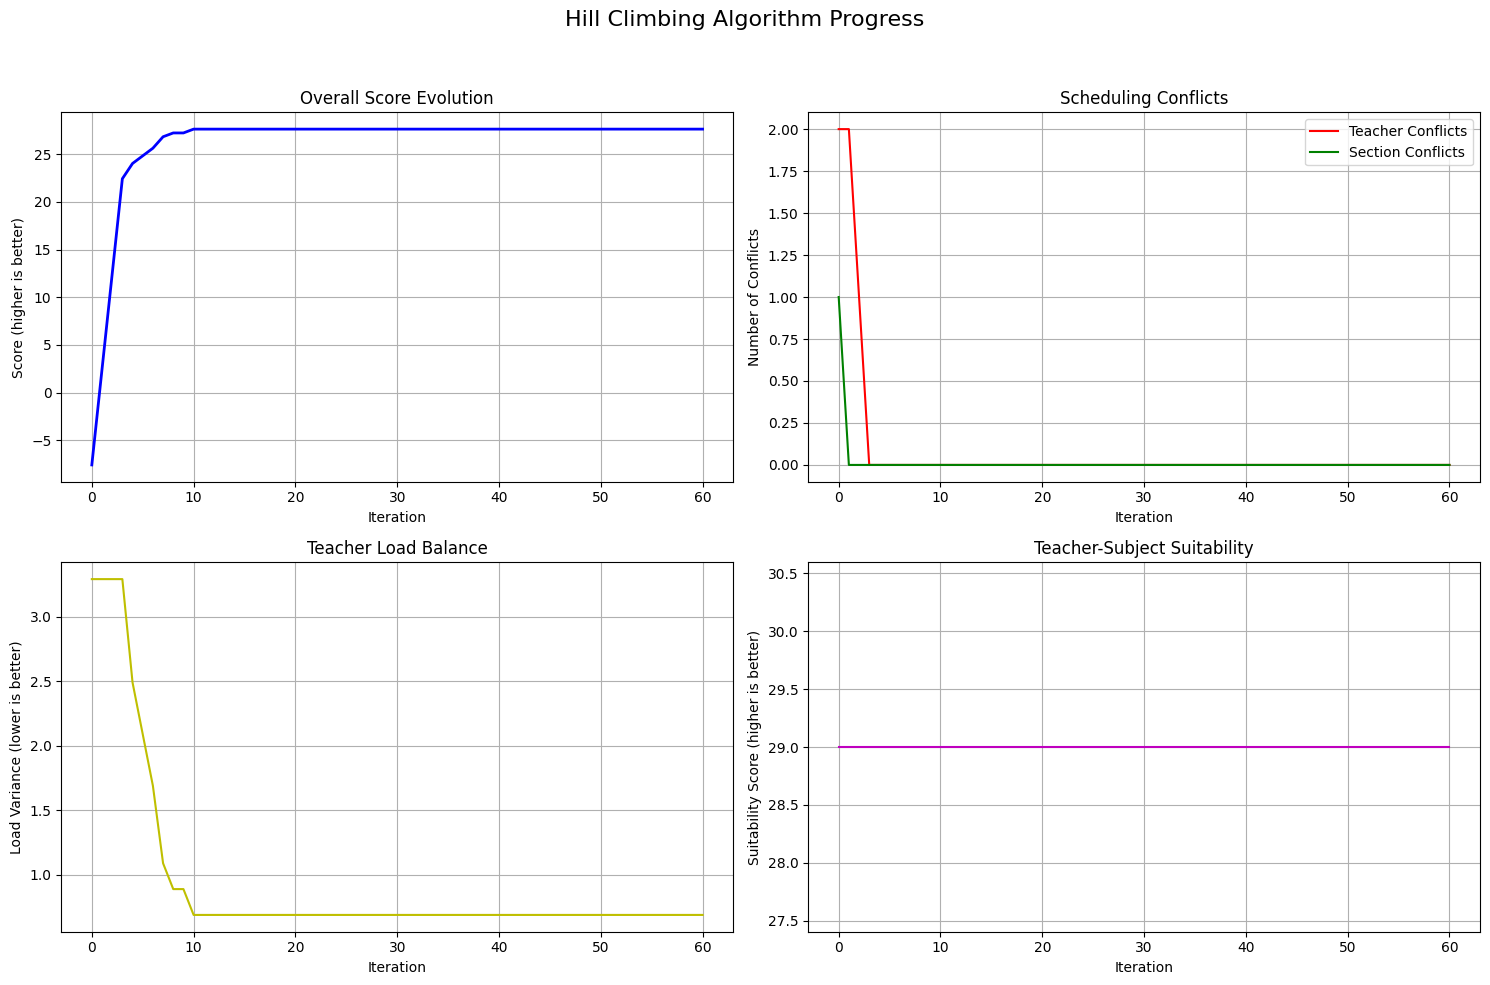

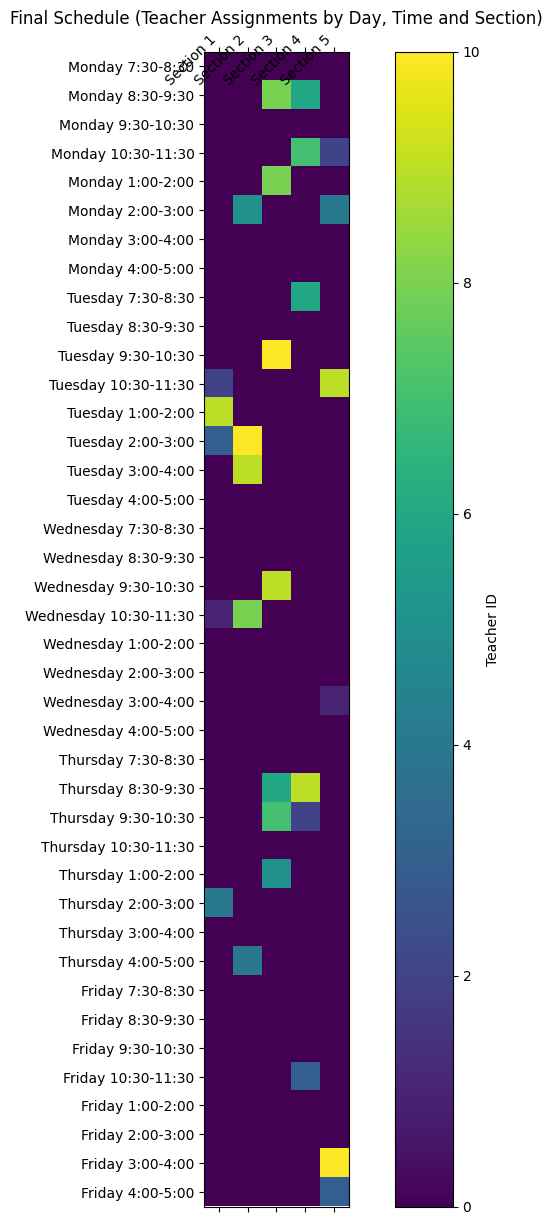

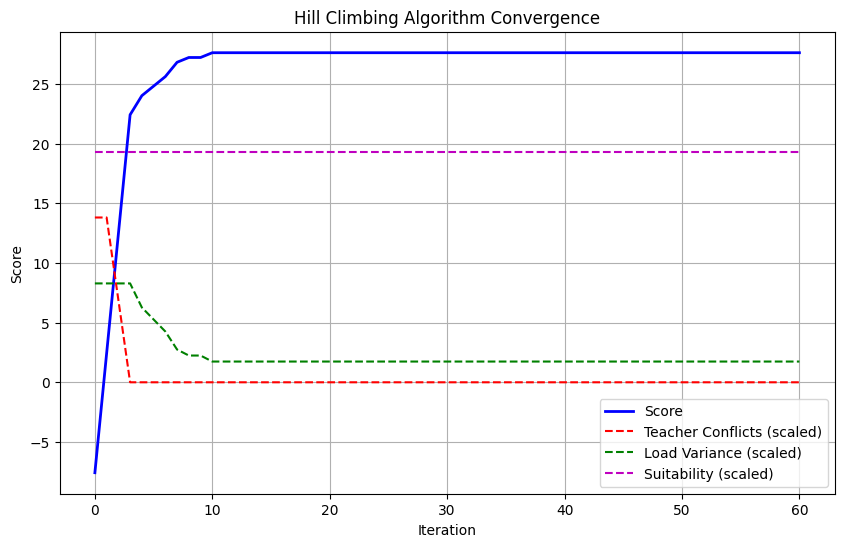

In [58]:
def run_visualization():
    """Run the visualization"""
    # Set seed for reproducibility
    random.seed(42)
    
    # Initialize scheduler
    scheduler = HillClimbingScheduler()
    
    # Run hill climbing
    print("Running hill climbing algorithm...")
    final_schedule, iterations = scheduler.climb()
    
    # Create visualizations
    progress_fig = scheduler.visualize_progress()
    schedule_fig = scheduler.visualize_final_schedule(final_schedule)
    
    # Save the figures
    #progress_fig.savefig('hill_climbing_progress.png')
    #schedule_fig.savefig('final_schedule_heatmap.png')
    
    # Show metrics summary
    _, final_metrics = scheduler._calculate_score(final_schedule)
    
    # Plot metrics improvement
    plt.figure(figsize=(10, 6))
    plt.plot(range(iterations+1), scheduler.score_history, 'b-', linewidth=2, label='Score')
    
    # Normalize metrics for better visualization
    norm_conflicts = [x/max(scheduler.teacher_conflicts_history) * max(scheduler.score_history) * 0.5 
                     for x in scheduler.teacher_conflicts_history]
    norm_variance = [x/max(scheduler.load_variance_history) * max(scheduler.score_history) * 0.3
                    for x in scheduler.load_variance_history]
    norm_suitability = [x/max(scheduler.suitability_history) * max(scheduler.score_history) * 0.7
                       for x in scheduler.suitability_history]
    
    plt.plot(range(iterations+1), norm_conflicts, 'r--', label='Teacher Conflicts (scaled)')
    plt.plot(range(iterations+1), norm_variance, 'g--', label='Load Variance (scaled)')
    plt.plot(range(iterations+1), norm_suitability, 'm--', label='Suitability (scaled)')
    
    plt.title('Hill Climbing Algorithm Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    #plt.savefig('convergence_metrics.png')
    
    # Display metrics table
    print("\nFinal Metrics:")
    print(f"Score: {scheduler.score_history[-1]}")
    print(f"Teacher conflicts: {final_metrics['teacher_conflicts']}")
    print(f"Section conflicts: {final_metrics['section_conflicts']}")
    print(f"Load variance: {final_metrics['load_variance']:.2f}")
    print(f"Suitability: {final_metrics['suitability']}")
    
    #print("\nVisualization complete! Check the saved PNG files.")
    
    # Showing the plots (uncomment if running in an interactive environment)
    # plt.show()
    
    return scheduler

if __name__ == "__main__":
    run_visualization()